In [130]:
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  

import requests
import time, logging, os, requests

import datetime
from datetime import timedelta
import statsmodels.api as sm

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import lightgbm as lgb

import warnings
import itertools

In [3]:
!ls

1-1-lgb.ipynb	figure.pdf	    simple_stat_id.csv.zip  train.csv .zip
11_stack.ipynb	hol.csv		    submission.csv	    trainmon.csv
1-2.ipynb	plot		    train_1.csv		    Untitled1.ipynb
dates.csv	simple_stat_id.csv  train.csv		    Untitled.ipynb


## Load

In [4]:
df = pd.read_csv('train.csv .zip', index_col = 'DATE')

In [5]:
df.head()

,ATM_ID,CLIENT_OUT
DATE,,
2015-01-01,0,91600
2015-01-02,0,136500
2015-01-03,0,335400
2015-01-04,0,379000
2015-01-05,0,344100


In [6]:
from sklearn.metrics import make_scorer

In [7]:
def score_series(y_true, y_pred):
    """
        Expects y_true and y_pred to be 1d arrays of the same lenght
    """
    return np.sum(np.abs(y_true - y_pred))/np.sum(np.abs(y_true))*10000

In [8]:
scorer = make_scorer(score_series)

### Plot

In [9]:
res = []
for i in df['ATM_ID'].unique():
    res.append([i, df[df['ATM_ID']==i]['CLIENT_OUT'].value_counts()[0], 
                df[df['ATM_ID']==i]['CLIENT_OUT'].mean(), df[df['ATM_ID']==i]['CLIENT_OUT'].median()])
    df[df['ATM_ID']==i]['CLIENT_OUT'].plot()
    plt.savefig('plot/id'+str(i)+'.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [10]:
res = pd.DataFrame(res, columns=['ATM_ID', 'NULL_C', 'MEAN', 'MEDIAN'])

In [11]:
res.sort_values(by='NULL_C').to_csv('simple_stat_id.csv', index=False)

In [12]:
df.index = pd.to_datetime(df.index)

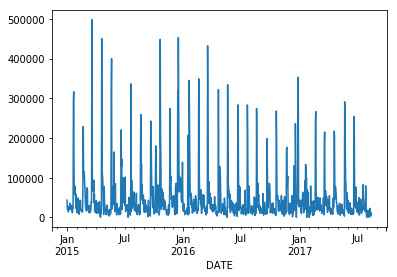

In [159]:
y = df[df['ATM_ID']==310]['CLIENT_OUT']
y.plot()

In [160]:
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 1)
SARIMAX: (0, 0, 1) x (0, 1, 0, 1)
SARIMAX: (0, 1, 0) x (0, 1, 1, 1)
SARIMAX: (0, 1, 0) x (1, 0, 0, 1)


In [161]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}1 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 1)1 - AIC:23945.348426511322
ARIMA(0, 0, 0)x(0, 1, 1, 1)1 - AIC:23840.591722144964
ARIMA(0, 0, 0)x(1, 0, 0, 1)1 - AIC:23806.062904911065
ARIMA(0, 0, 0)x(1, 0, 1, 1)1 - AIC:23781.24160897587
ARIMA(0, 0, 0)x(1, 1, 0, 1)1 - AIC:23924.096699023805
ARIMA(0, 0, 0)x(1, 1, 1, 1)1 - AIC:23661.63955292487
ARIMA(0, 0, 1)x(0, 0, 0, 1)1 - AIC:23945.348426511322
ARIMA(0, 0, 1)x(0, 0, 1, 1)1 - AIC:23882.97099767138
ARIMA(0, 0, 1)x(0, 1, 0, 1)1 - AIC:23840.591722144964
ARIMA(0, 0, 1)x(0, 1, 1, 1)1 - AIC:23850.182496761874
ARIMA(0, 0, 1)x(1, 0, 0, 1)1 - AIC:23820.125974776725
ARIMA(0, 0, 1)x(1, 0, 1, 1)1 - AIC:23734.320043361207
ARIMA(0, 0, 1)x(1, 1, 0, 1)1 - AIC:23671.108853392696
ARIMA(0, 0, 1)x(1, 1, 1, 1)1 - AIC:23643.351097082756
ARIMA(0, 1, 0)x(0, 0, 1, 1)1 - AIC:23840.591722144964
ARIMA(0, 1, 0)x(0, 1, 1, 1)1 - AIC:23966.98085895952
ARIMA(0, 1, 0)x(1, 0, 0, 1)1 - AIC:23924.096699023805
ARIMA(0, 1, 0)x(1, 0, 1, 1)1 - AIC:23661.63955292487
ARIMA(0, 1, 0)x(1, 1, 0, 1)1 - AI

(1, 1, 1)x(0, 0, 1, 1)1

In [162]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3238      0.056      5.743      0.000       0.213       0.434
ma.L1         -0.9973      0.005   -215.412      0.000      -1.006      -0.988
ma.S.L1        0.1698      0.062      2.737      0.006       0.048       0.291
sigma2       3.89e+09   2.21e-11   1.76e+20      0.000    3.89e+09    3.89e+09


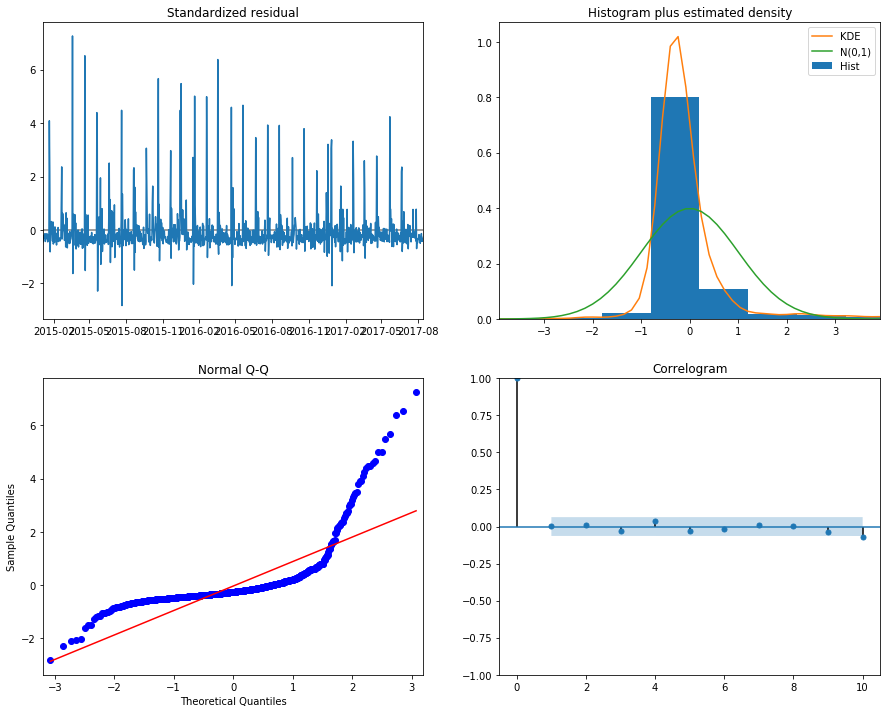

In [165]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [166]:
results.get_prediction()

In [167]:
pred = results.get_prediction(start = pd.to_datetime('2017-08-15') ,end=pd.to_datetime('2017-09-17'), dynamic=False)
pred_ci = pred.conf_int()

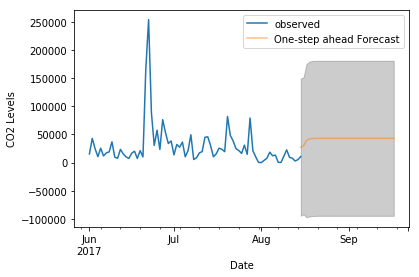

In [177]:
ax = y['2017-06':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.5)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [179]:
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

predicted=94012.867804, expected=25400.000000
predicted=33357.851433, expected=70600.000000
predicted=80440.171254, expected=86200.000000
predicted=77315.175728, expected=45000.000000
predicted=52064.694175, expected=56400.000000
predicted=63746.245100, expected=57300.000000
predicted=65084.512353, expected=17500.000000
predicted=31641.289079, expected=31200.000000
predicted=37304.588109, expected=25900.000000
predicted=42895.724313, expected=10200.000000
predicted=27706.178808, expected=26500.000000
predicted=48581.520347, expected=15300.000000
predicted=43720.293080, expected=18700.000000
predicted=37606.720397, expected=12600.000000
predicted=29682.242229, expected=11200.000000
predicted=30113.931407, expected=20800.000000
predicted=42419.051452, expected=21500.000000
predicted=20373.986906, expected=10000.000000
predicted=33707.019231, expected=59700.000000
predicted=67414.491269, expected=14900.000000
predicted=43264.609623, expected=5400.000000
predicted=36984.024645, expected=38

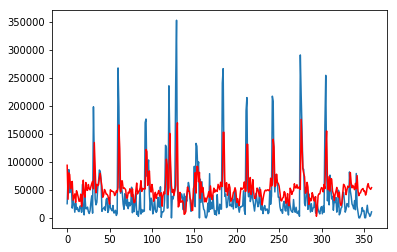

In [189]:
# split dataset
X = y.values
train, test = X[1:len(X)-360], X[len(X)-360:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = score_series(test, predictions)
print('Test score: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()